### PPI networks for selected AD risk genes in xQTL loci
Author: Ru Feng and Jenny Empawi

#### Load libraries

In [1]:
library(STRINGdb)
library(dplyr)
library(igraph)
library(tidygraph)
library(ggraph)
library(data.table)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:igraph’:

    groups


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
✔ readr

#### Load gene list and twas list

In [2]:
twas_list <- fread("/Staging/variant_gene_summary/AD_xQTL_integration_summary/AD_genes_FunGen_AD_twas_GVC_xQTL_20250325.tsv")  #FIXME
gene_list <- fread("/Staging/variant_gene_summary/AD_xQTL_integration_summary/AD_genes_FunGen_AD_GVC_xQTL_20250325.tsv")  #FIXME

In [3]:
# Initialize STRINGdb (change species if needed, 9606 = Homo sapiens)
string_db <- STRINGdb$new(version="11.5", species=9606, score_threshold=400, input_directory="")

# Example gene list (use your own gene symbols or Entrez IDs)
xQTL_list <- gene_list %>% filter(str_detect(data_resources, 'FunGen_xQTL'))
genes <- xQTL_list$gene_name

# Map gene names to STRING IDs
mapped_genes <- string_db$map(data.frame(gene=genes), "gene", removeUnmappedRows = TRUE)

# Retrieve interaction network for the genes
ppi_network <- string_db$get_interactions(mapped_genes$STRING_id)

In [4]:
ppi_network_unique <- ppi_network %>%
  mutate(pair = paste0(pmin(from, to), "_", pmax(from, to))) %>%
  distinct(pair, .keep_all = TRUE)

In [5]:
genes_with_ppi <- mapped_genes %>% filter(STRING_id %in% c(ppi_network$from, ppi_network$to))
genes_with_ppi %>% dim 

[1] 186   2

In [6]:
xQTL_list %>% pull(resource_in_FunGen_xQTL) %>% table
xQTL_list %>% dim
xQTL_list %>% filter(!(gene_name %in% genes_with_ppi$gene)) %>% pull(resource_in_FunGen_xQTL) %>% table # the xQTL genes not have any PPI

.
                                                  ColocBoost 
                                                         160 
                                    ColocBoost,multi_context 
                                                           2 
                         ColocBoost,multi_context,multi_gene 
                                                           1 
                                   ColocBoost,single_context 
                                                           7 
                         ColocBoost,single_context,MetaBrain 
                                                           1 
              ColocBoost,single_context,MetaBrain,multi_gene 
                                                           1 
                     ColocBoost,single_context,multi_context 
                                                          12 
           ColocBoost,single_context,multi_context,MetaBrain 
                                                           7 
ColocB

[1] 240   7

.
                                                  ColocBoost 
                                                          40 
                                   ColocBoost,single_context 
                                                           2 
                     ColocBoost,single_context,multi_context 
                                                           2 
           ColocBoost,single_context,multi_context,MetaBrain 
                                                           1 
                        ColocBoost,single_context,multi_gene 
                                                           1 
                                                   MetaBrain 
                                                           2 
                                        MetaBrain,ColocBoost 
                                                           1 
                                              single_context 
                                                           1 
      

In [7]:
gvc_list <- gene_list %>% filter(str_detect(data_resources, 'FunGen_AD_PI|ADSP_GVC'))
real_gvc_list <- gene_list %>% filter(str_detect(data_resources, 'ADSP_GVC')) # 20 genes from GVC table2

In [8]:
xQTL_only <- Reduce(setdiff, list(xQTL_list$gene_id, gvc_list$gene_id, twas_list$gene_id)) # the genes unqiue from xQTL, NOT from gvc and twas
xQTL_only <- xQTL_list %>% filter(gene_id %in% xQTL_only)
xQTL_only %>% dim
xQTL_only %>% pull(resource_in_FunGen_xQTL) %>% table

[1] 151   7

.
                                                  ColocBoost 
                                                         116 
                         ColocBoost,multi_context,multi_gene 
                                                           1 
                                   ColocBoost,single_context 
                                                           1 
                     ColocBoost,single_context,multi_context 
                                                           4 
           ColocBoost,single_context,multi_context,MetaBrain 
                                                           2 
ColocBoost,single_context,multi_context,MetaBrain,multi_gene 
                                                           2 
                        ColocBoost,single_context,multi_gene 
                                                           2 
                                                   MetaBrain 
                                                           1 
      

In [9]:
cb_apr25 <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/ad_xqtl_colocboost_export_filtered.bed.gz') #FIXME
cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id) %>% pull(gene_ID) %>% unique %>% length # 128 xQTL only genes are from colocboost
#cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id)  %>% mutate(n_count = str_count(event_ID, ';') + 1)  %>% filter(n_count == 2) %>% pull(gene_ID) %>% unique %>% length

[1] 128

In [10]:
xQTL_only_1_se_cb <- cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id)  %>% 
              mutate(n_count = str_count(event_ID, ';') + 1, 
                     only_1_se = ifelse((str_detect(event_ID, 'sQTL') & n_count == 2), TRUE, FALSE)) %>% filter(only_1_se)
xQTL_only_1_se_cb %>% pull(gene_ID) %>% unique %>% length # should we filter the genes that only colocalized between 1 splicing event and AD? although that is not much
gene_ref <- fread('/restricted/projectnb/xqtl/jaempawi/xqtl/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list') #FIXME
xQTL_only_1_se_cb <- xQTL_only_1_se_cb %>% merge(., gene_ref %>% select('gene_id', 'gene_name'), by.x = 'gene_ID', by.y = 'gene_id')

[1] 35

In [11]:
# whether the genes from ColocBoost are siginificant different from all genes and PPI genes
# Create contingency table
#            | PPI     | No PPI
# ---------- | ------- | -------
# methodA    | 120     | 40
# notMethodA | 66      | 14

# Total genes with PPI = 186
# Total genes without PPI = 240 - 186 = 54
# Total methodA = 160; of which 40 are without PPI → 120 with PPI
# Total not methodA = 80; of which 14 are without PPI → 66 with PPI

mat <- matrix(c(120, 40, 66, 14), nrow = 2,
              dimnames = list(Method = c("methodA", "notMethodA"),
                              PPI = c("PPI", "No_PPI")))

# Perform Fisher's exact test
fisher.test(mat)


	Fisher's Exact Test for Count Data

data:  mat
p-value = 0.2508
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.297715 1.302572
sample estimates:
odds ratio 
 0.6375147 


In [12]:
symbol_lookup <- dplyr::select(mapped_genes, STRING_id, gene)
symbol_lookup <- dplyr::distinct(symbol_lookup)

In [13]:
# Build igraph object
g <- graph_from_data_frame(ppi_network[, c("from", "to")], directed=FALSE)
g <- igraph::simplify(g, remove.multiple = TRUE, remove.loops = TRUE)
# Replace vertex names with gene symbols
V(g)$name <- symbol_lookup$gene[match(V(g)$name, symbol_lookup$STRING_id)]
# Optional: make highlighted genes larger
# V(g)$size <- ifelse(V(g)$name %in% highlight_genes, 8, 4)


#### xQTL only genes labelled by methods 

In [14]:
xQTL_shared_method <- xQTL_list %>% filter(gene_name %in% genes_with_ppi$gene, gene_name %in% xQTL_only$gene_name) %>% filter(str_detect(resource_in_FunGen_xQTL, ',')) %>% pull(gene_name)

In [15]:
tg <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% real_gvc_list$gene_name, "GVC", # highlight GVC2 genes as 'core genes'
                            ifelse(name %in% xQTL_shared_method, "xQTL_only_shared_method", # the genes are xQTL only, but more than 1 methods
                                   ifelse(name %in% xQTL_only_1_se_cb$gene_name, "xQTL_only_only_1_se_cb", # the genes are only from 1 splicing event colocalized results, which are alarming
                                       ifelse(name %in% xQTL_only$gene_name, "xQTL_only_single_method", "shared"))))) # the genes are xQTL only but only from one methods / shared with GVC or TWAS

Warning message:
“ggrepel: 20 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


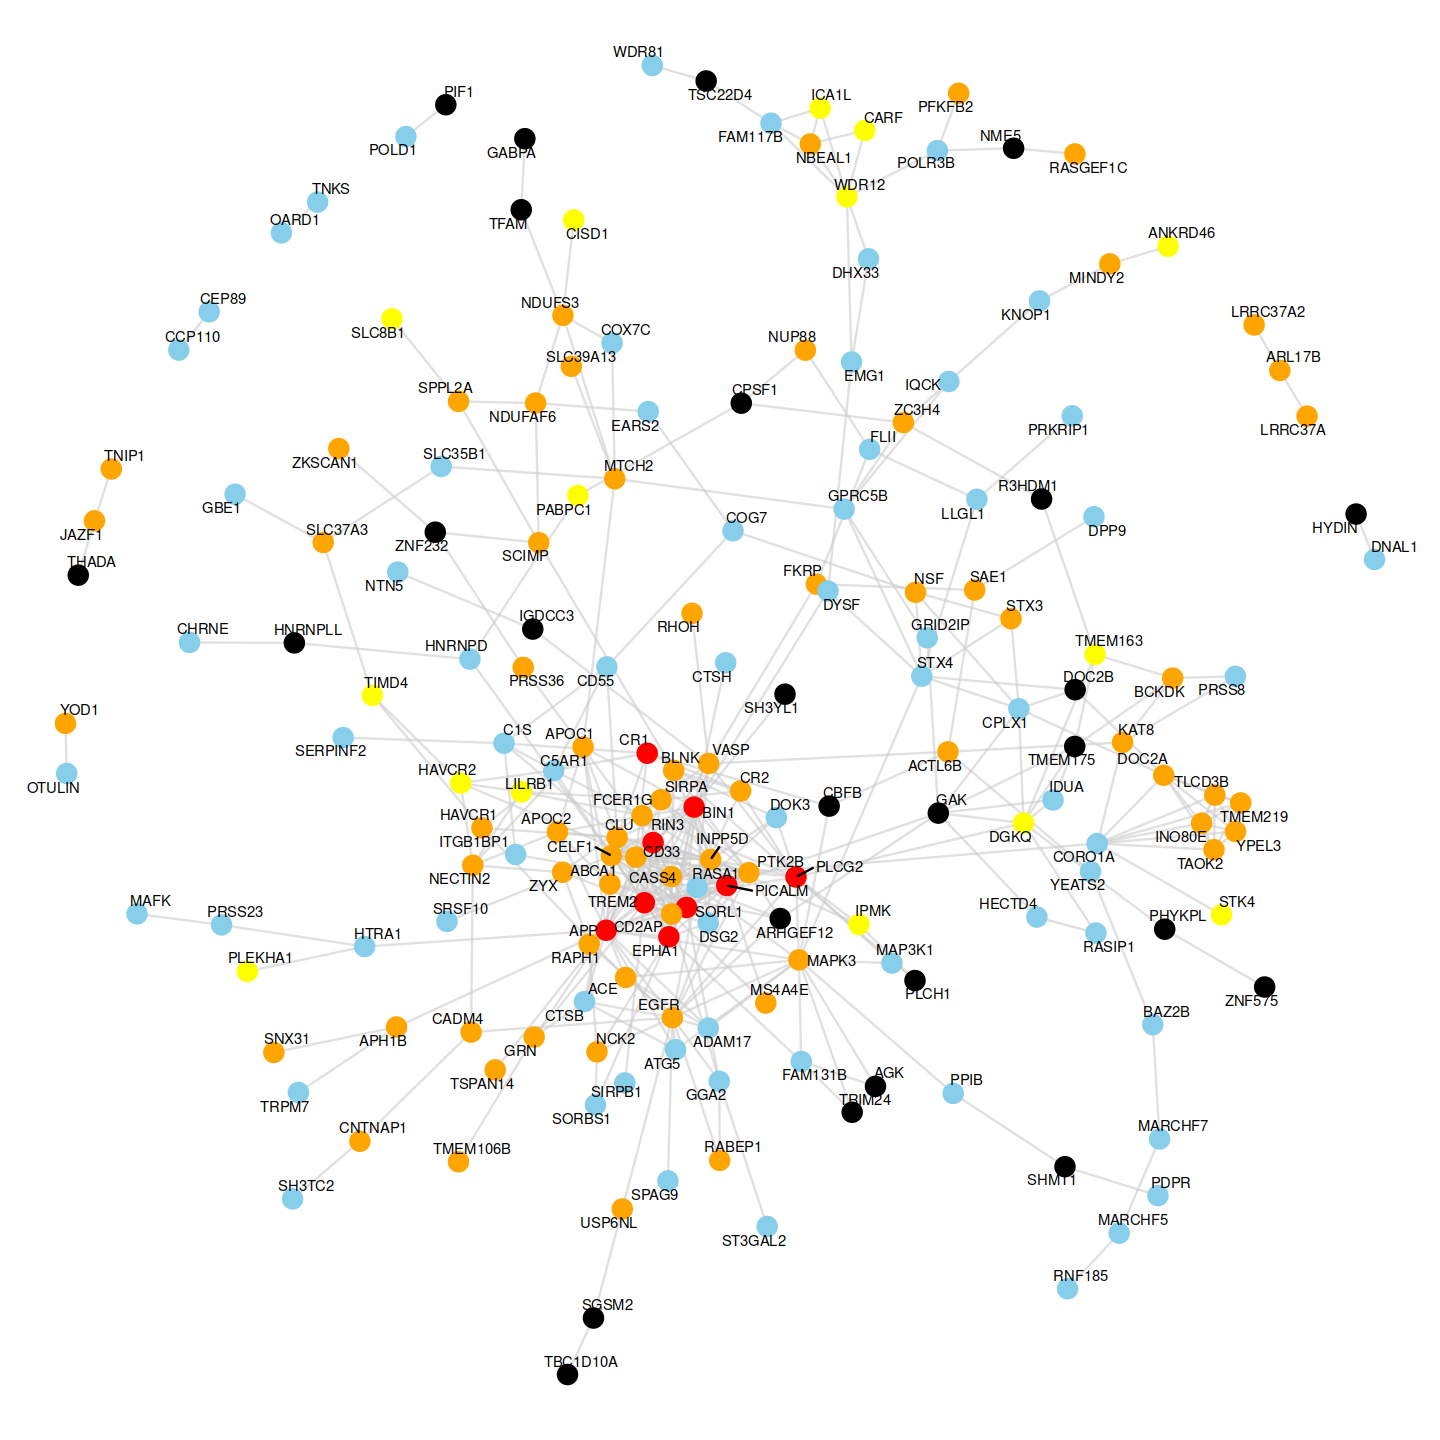

In [29]:
set.seed(123)
options(repr.plot.width = 12, repr.plot.height = 12)
p1 <- ggraph(tg, layout = "fr") +  # fr: Fruchterman-Reingold layout
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("GVC" = "red", "shared" = "orange", "xQTL_only_shared_method" = "yellow", "xQTL_only_only_1_se_cb" = "black", "xQTL_only_single_method" = "skyblue")) +
  theme_void() +
  theme(legend.position = "none")

p1

#### xQTL only genes labelled by non proxy AD genes 

In [30]:
nonproxy_ad_genes <- readLines('/restricted/projectnb/xqtl/jaempawi/xqtl/Non_proxy_AD_gene_xQTL.txt')  #FIXME
nonproxy_ad_genes_names <- gene_ref %>% filter(gene_id %in% nonproxy_ad_genes) %>% pull(gene_name)
nonproxy_ad_genes_names %>% length

[1] 128

In [31]:
tg_non_proxy <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% nonproxy_ad_genes_names, "Non_proxy_AD_genes", "Others")) # the genes are xQTL only but only from one methods / shared with GVC or TWAS

Warning message:
“ggrepel: 69 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


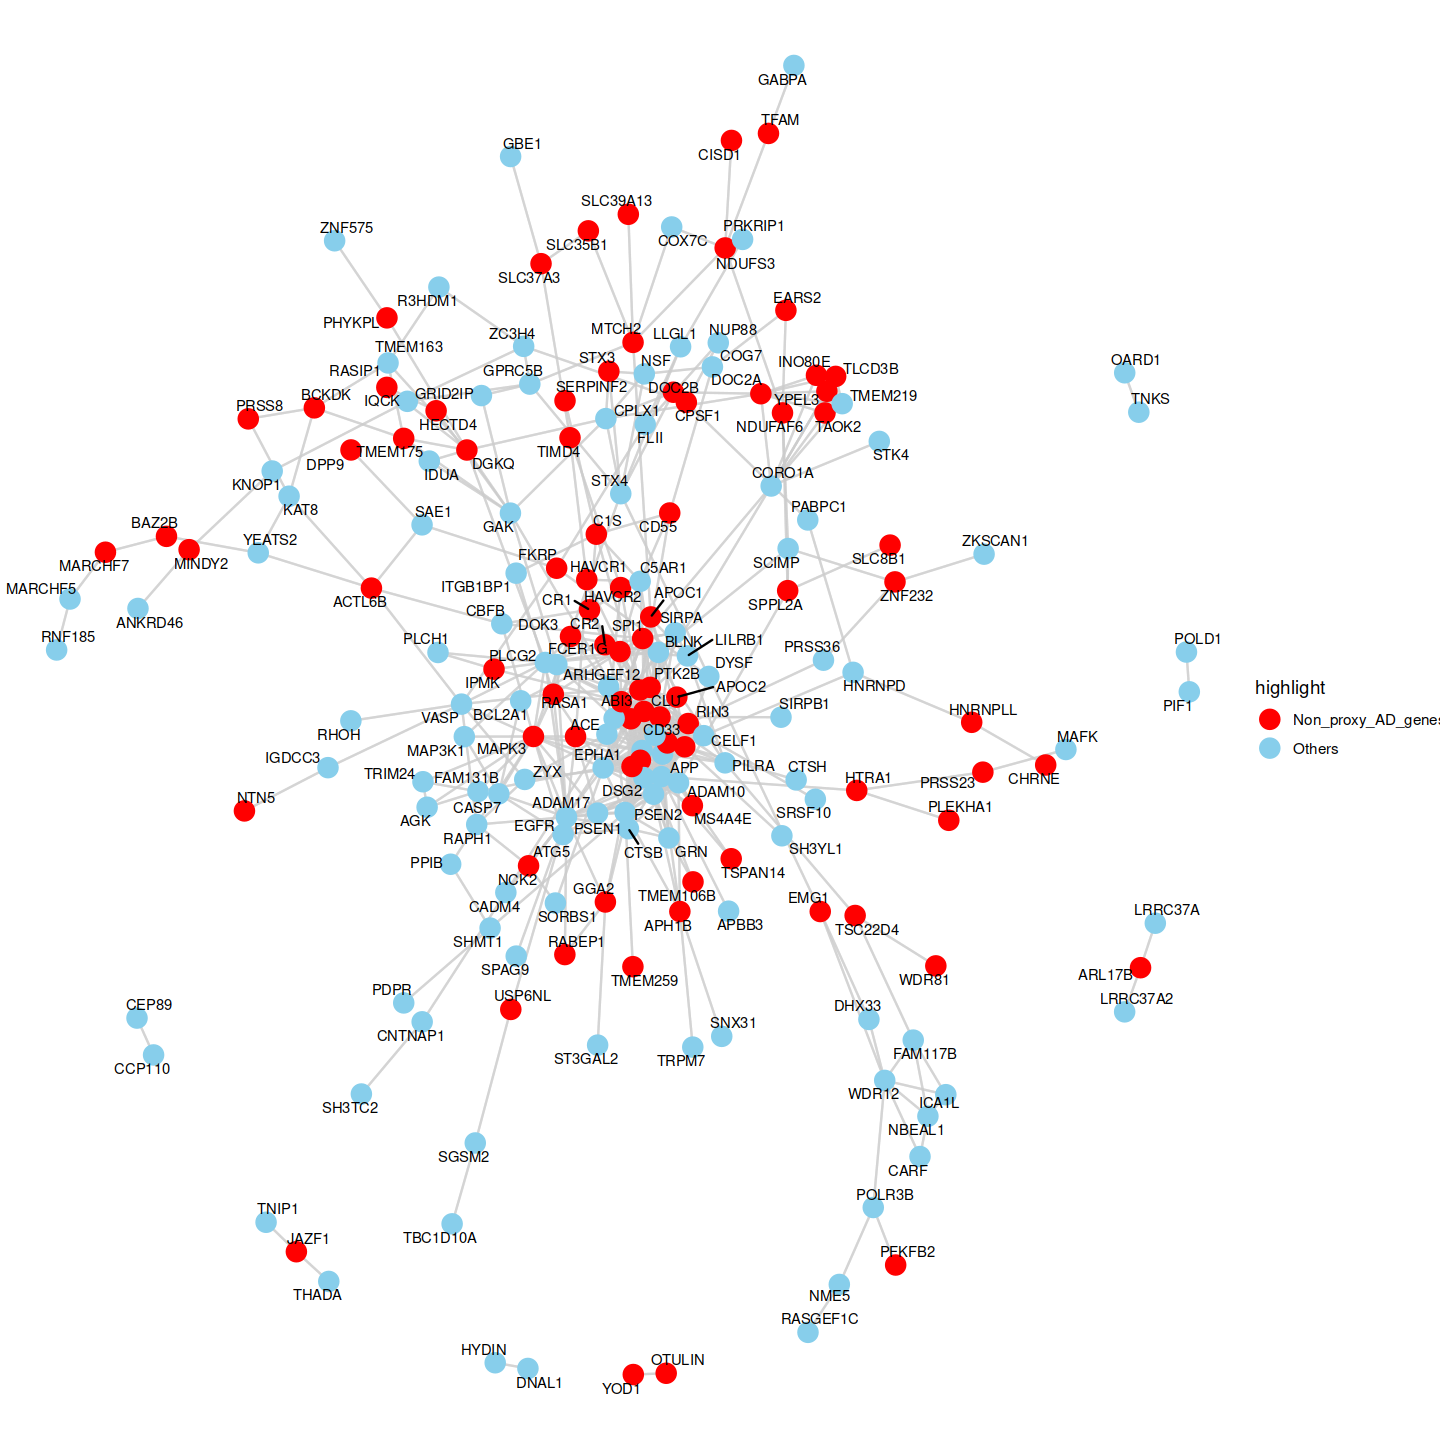

In [32]:
set.seed(123)
options(repr.plot.width = 12, repr.plot.height = 12)
p2 <- ggraph(tg_non_proxy, layout = "fr") +  # fr: Fruchterman-Reingold layout
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("Non_proxy_AD_genes" = "red", "Others" = "skyblue")) +
  theme_void() 
p2

In [33]:
which(tg['DYSF',]>0)

STX4 BIN1 FKRP EMG1 
  45   57   92  182

### xQTL + GVS table2

In [34]:
# Example gene list (use your own gene symbols or Entrez IDs)
genes <- c(xQTL_list$gene_name, real_gvc_list$gene_name) %>% unique 

# Map gene names to STRING IDs
mapped_genes <- string_db$map(data.frame(gene=genes), "gene", removeUnmappedRows = TRUE)

# Retrieve interaction network for the genes
ppi_network <- string_db$get_interactions(mapped_genes$STRING_id)

In [35]:
ppi_network_unique <- ppi_network %>%
  mutate(pair = paste0(pmin(from, to), "_", pmax(from, to))) %>%
  distinct(pair, .keep_all = TRUE)

In [36]:
symbol_lookup <- dplyr::select(mapped_genes, STRING_id, gene)
symbol_lookup <- dplyr::distinct(symbol_lookup)

In [37]:
# Build igraph object
g <- graph_from_data_frame(ppi_network[, c("from", "to")], directed=FALSE)
g <- simplify(g)
# Replace vertex names with gene symbols
V(g)$name <- symbol_lookup$gene[match(V(g)$name, symbol_lookup$STRING_id)]
# Define genes to highlight
highlight_genes <- real_gvc_list$gene_name

# Assign color: red for highlighted, gray for others
V(g)$color <- ifelse(V(g)$name %in% highlight_genes, "red", "gray")

# Optional: make highlighted genes larger
V(g)$size <- ifelse(V(g)$name %in% highlight_genes, 8, 4)

In [38]:
tg_real_gvc <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% real_gvc_list$gene_name, "Yes", "No"))

In [39]:
which(tg['CORO1A',] > 0)

TAOK2   DOC2A   PTK2B  TLCD3B   YPEL3  INO80E    STK4 TMEM219 
     53      71      84      86     113     114     141     178

Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


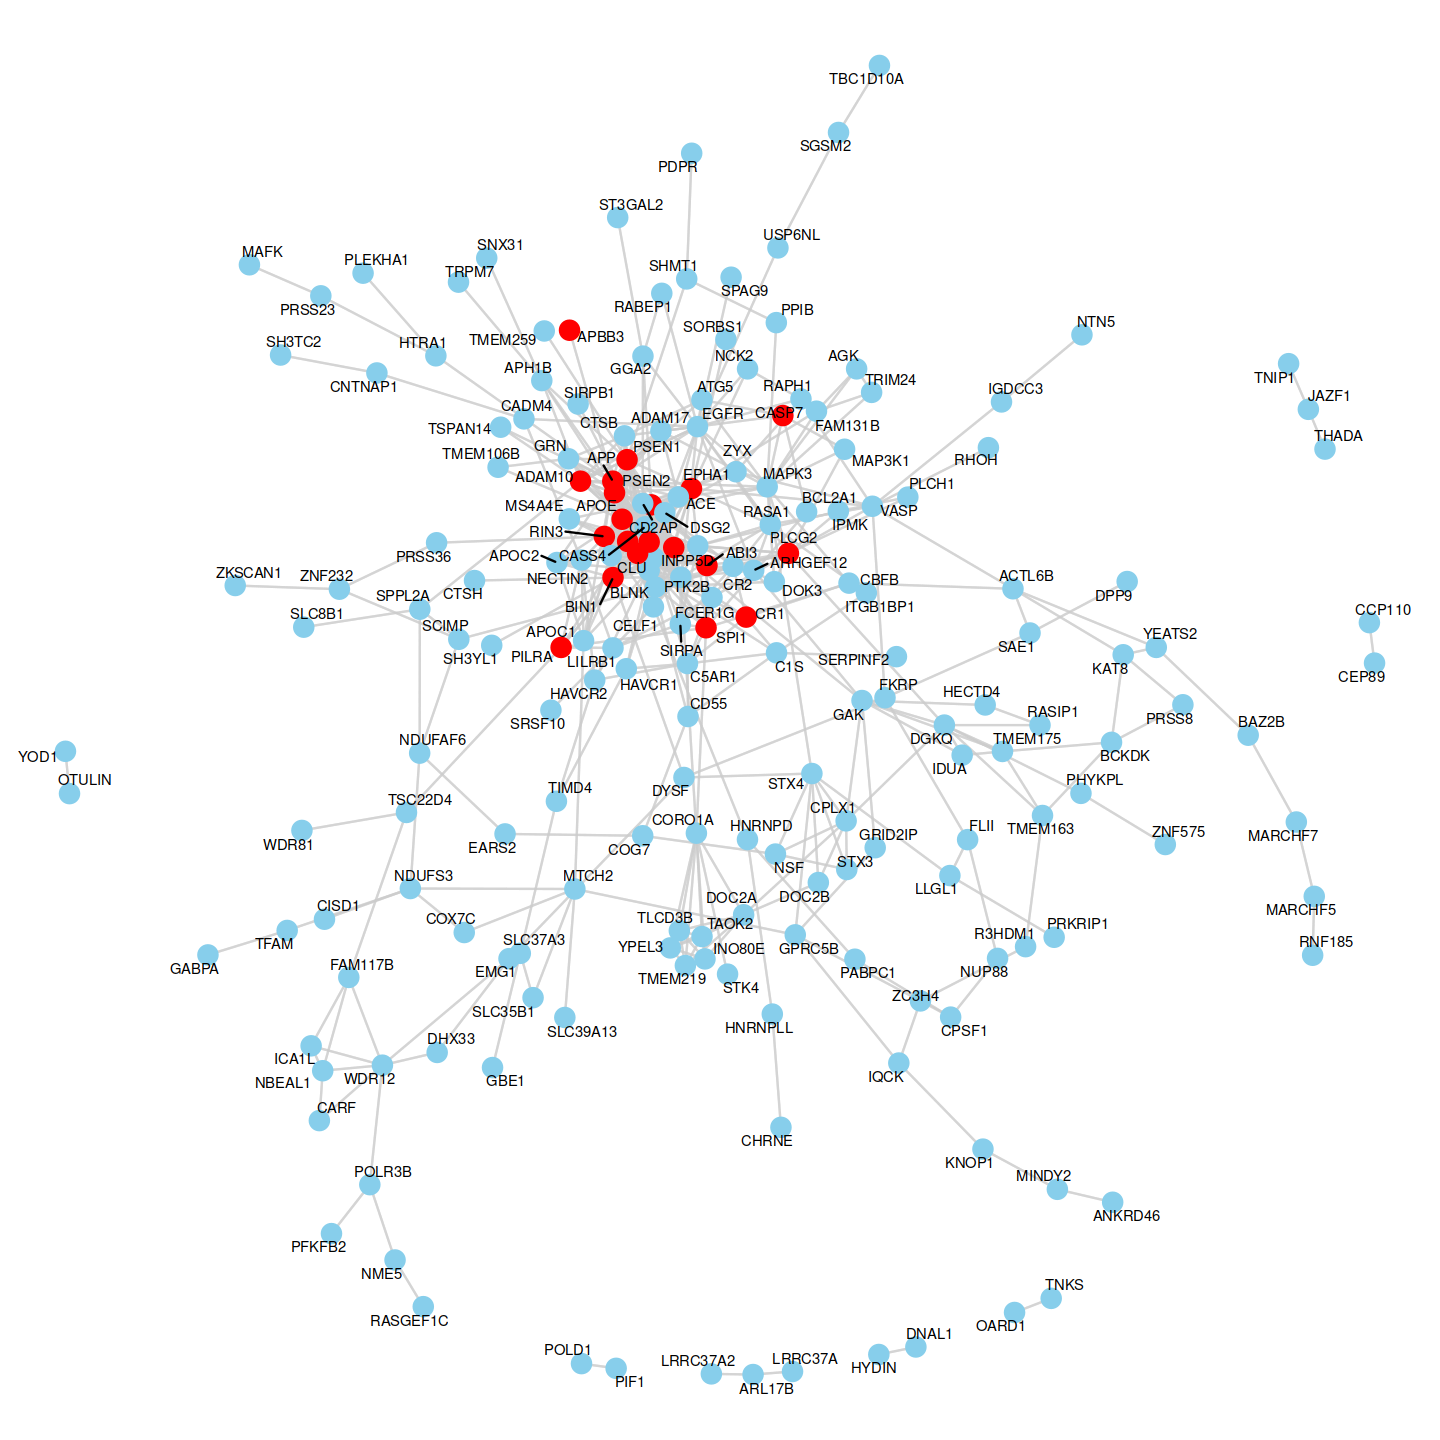

In [40]:
options(repr.plot.width = 12, repr.plot.height = 12)
p3 <- ggraph(tg_real_gvc, layout = "fr") +  # fr: Fruchterman-Reingold s
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("Yes" = "red", "No" = "skyblue")) +
  theme_void() +
  theme(legend.position = "none")
p3